Note:  This notebook has widgets to select the state, congressional district and facility.  Those currently work only when the cells are run one at a time sequentially, not all at once.

## Clean Air Act Formal Enforcements by Congressional District

This notebook examines ECHO data using CASE_FACILITIES, CASE_ENFORCEMENTS and ECHO_EXPORTER.
The fields in the CASE_FACILITIES table are:
<ol>
    <li>REGISTRY_ID, </li>
    <li>CASE_NUMBER. </li>
</ol>
The fields in the CASE_ENFORCEMENTS table are:
<ol>
    <li>CASE_NUMBER, </li>
    <li>FISCAL_YEAR, </li>
    <li>CASE_STATUS_DATE, </li>
    <li>HQ_DIVISION. </li>
</ol>
The CASE_NUMBER field links these tables.

The REGISTRY_ID identifier is linked to the ECHO_EXPORTER table's field of the same name.

The HQ_DIVISION of interest for this notebook is 'CAA'.
    
A state and congressional district must be chosen using the dropdown
widgets that are provided.

In [1]:
# Import libraries
import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display


In [2]:
#data_location = "https://github.com/edgi-govdata-archiving/echo-data/blob/master/ECHO_EXPORTER.csv?raw=true" # Where the ECHO data is saved
#sql="SELECT * FROM ECHO_EXPORTER as e,`ICIS-AIR_FACILITIES` as f,`ICIS-AIR_VIOLATION_HISTORY` as h  where  e.FAC_ZIP=f.ZIP_CODE and f.PGM_SYS_ID=h.PGM_SYS_ID and f.ZIP_CODE=%s" %(my_zip)
#sql='show tables'  
#sql= 'show columns from `ECHO_EXPORTER` '

sql = "select REGISTRY_ID, FAC_NAME, FAC_STATE, FAC_LAT, FAC_LONG, FAC_DERIVED_CD113 from ECHO_EXPORTER where AIR_FLAG = 'Y'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)
print(sql)
print(data_location)


select REGISTRY_ID, FAC_NAME, FAC_STATE, FAC_LAT, FAC_LONG, FAC_DERIVED_CD113 from ECHO_EXPORTER where AIR_FLAG = 'Y'
http://apps.tlt.stonybrook.edu/echoepa/?query=select%20REGISTRY_ID%2C%20FAC_NAME%2C%20FAC_STATE%2C%20FAC_LAT%2C%20FAC_LONG%2C%20FAC_DERIVED_CD113%20from%20ECHO_EXPORTER%20where%20AIR_FLAG%20%3D%20%27Y%27


In [3]:

echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
echo_data.set_index( "REGISTRY_ID", inplace=True)

# local_data_location = "../../ICIS_Air_Violation/ECHO_EXPORTER-Air.csv"
# echo_data = pd.read_csv(local_data_location,encoding='iso-8859-1',header = 0)


Run this next cell, select a state, and then run the following cell.

In [5]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
dropdown_state=widgets.Dropdown(
    options=states,
    value='NY',
    description='State:',
    disabled=False,
)
output_state = widgets.Output()
my_state = ""

def dropdown_state_eventhandler( change ):
    output_state.clear_output()
    value = change.new
    with output_state:
        display( change.new )
        # if ( change.new == "all" ):
        #     display( echo_data )
        # else:
        #     display( echo_data[echo_data["FAC_STATE"] == change.new] )
            
dropdown_state.observe( dropdown_state_eventhandler, names='value')
display( dropdown_state )

Dropdown(description='State:', index=32, options=('AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', …

Run this next cell after choosing a state from the dropdown list.

In [6]:
my_state = dropdown_state.value
my_state_facs = echo_data[echo_data["FAC_STATE"] == my_state]

num_facilities = my_state_facs.shape[0]
print("There are %s ICIS facilities in %s tracked in the ECHO database." %(num_facilities, my_state))

There are 12702 ICIS facilities in LA tracked in the ECHO database.


Run this next cell to generate the Congressional District dropdown list for your state.  Then select a CD and run the following cell.

In [7]:
if (( my_state != 'none' ) & (my_state != 'all' )):
    cd_array = my_state_facs["FAC_DERIVED_CD113"].fillna(0).astype(int).unique()
    cd_array.sort()
    w2=widgets.Dropdown(
        options=cd_array,
        value=1,
        description='Congressional Districts:',
        disabled=False,
    )
    display(w2)

Dropdown(description='Congressional Districts:', index=1, options=(0, 1, 2, 3, 4, 5, 6, 18), value=1)

Run this next cell after choosing a congressional district from the dropdown list.

In [8]:
my_cd = w2.value
my_cd_facs = my_state_facs[my_state_facs["FAC_DERIVED_CD113"].fillna(0).astype(int) == my_cd]
num_facilities = my_cd_facs.shape[0]    
print("There are %s ICIS facilities in %s district %s tracked in the ECHO database." %(num_facilities, my_state, my_cd))

There are 609 ICIS facilities in LA district 2 tracked in the ECHO database.


Next look up the compliance monitoring history for the facilities in the selected
state and congressional district.  This step may take awhile.

In [16]:
# sql = "select PGM_SYS_ID, STATE_EPA_FLAG, AGENCY_TYPE_DESC, COMP_MONITOR_DESC, ACTUAL_END_DATE from `ICIS-AIR_FCES_PCES` where STATE_CODE='" + my_state + "'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='

sql = "select CF.REGISTRY_ID, CE.FISCAL_YEAR, CE.CASE_STATUS_DATE from `CASE_FACILITIES` CF, `CASE_ENFORCEMENTS` CE" + \
   " where CE.HQ_DIVISION = 'AIR' and CE.CASE_NUMBER = CF.CASE_NUMBER"
# sql = "select distinct( HQ_DIVISION ) from CASE_ENFORCEMENTS"
# sql = "show columns from `ICIS_FEC_EPA_INSPECTIONS`"
# sql = "show tables from slim_echoepa_a"
data_location=url+urllib.parse.quote(sql)
print(sql)
print(data_location)

select CF.REGISTRY_ID, CE.FISCAL_YEAR, CE.CASE_STATUS_DATE from `CASE_FACILITIES` CF, `CASE_ENFORCEMENTS` CE where CE.HQ_DIVISION = 'AIR' and CE.CASE_NUMBER = CF.CASE_NUMBER
http://apps.tlt.stonybrook.edu/echoepa/?query=select%20CF.REGISTRY_ID%2C%20CE.FISCAL_YEAR%2C%20CE.CASE_STATUS_DATE%20from%20%60CASE_FACILITIES%60%20CF%2C%20%60CASE_ENFORCEMENTS%60%20CE%20where%20CE.HQ_DIVISION%20%3D%20%27AIR%27%20and%20CE.CASE_NUMBER%20%3D%20CF.CASE_NUMBER


In [17]:
icis_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
icis_data.set_index( "REGISTRY_ID", inplace=True)

In [18]:
icis_data

,FISCAL_YEAR,CASE_STATUS_DATE
REGISTRY_ID,,
110001565244,1990,07/01/1991
110010601795,1990,07/01/1991
110009344021,1984,10/28/1983
110009327022,1988,03/03/1989
110009327022,1989,12/30/1988
...,...,...
110000747924,1999,07/17/2019
110043788327,1999,07/17/2019
110000382069,1999,07/17/2019


In [19]:
# Find the facility that matches the inspection, by REGISTRY_ID.

my_cd_icis = pd.DataFrame()
no_data_ids = []
# Look through all facilities in my CD.
for fac in my_cd_facs.itertuples():
    # breakpoint()
    fac_id = fac.Index
    try:
        enforcements = icis_data.loc[ fac_id ].copy()
        # breakpoint()
        n = enforcements.shape[0]
        fac_list = [fac.Index] * n
        enforcements['facility'] = fac_list
        frames = [my_cd_icis, enforcements]
        my_cd_icis = pd.concat( frames, ignore_index=False )
    except KeyError:
        # The facility wasn't found in the ICIS_FEC_EPA_INSPECTIONS data.
        no_data_ids.append( fac.Index )
    
my_cd_icis.to_csv( r'my_cd_enforcements.csv', index=True, header=True )
# with open( "no_data_ids.txt", "w" ) as output:
#     output.write( str( no_data_ids ))

Map the facilities that have had these compliance evaluations.

In [20]:

print( "Facilities without enforcements: " + str( len( no_data_ids )))
print( "Facilities with enforcements: " + str( len( my_cd_icis )))
my_cd_icis

Facilities without enforcements: 586
Facilities with enforcements: 198


,0,CASE_STATUS_DATE,FISCAL_YEAR,facility
110000597104,NaN,01/18/2001,2000.0,1.100006e+11
110000597104,NaN,01/18/2001,2000.0,1.100006e+11
110000597104,NaN,08/10/1999,1999.0,1.100006e+11
110000597104,NaN,08/10/1999,1999.0,1.100006e+11
110041135580,NaN,12/13/2012,1999.0,1.100411e+11
...,...,...,...,...
110000613747,NaN,06/12/1997,1997.0,1.100006e+11
110000613747,NaN,06/12/1997,1997.0,1.100006e+11
110000613747,NaN,03/24/2000,2000.0,1.100006e+11
110000613747,NaN,03/24/2000,2000.0,1.100006e+11


In [21]:
fac_idx_list = my_cd_icis['facility'].dropna()
fac_cd_icis = my_cd_facs.loc[fac_idx_list]

In [22]:
# Let's show a quick map of your area and the facilities in it

def mapper(df):
    # Initialize the map
    m = folium.Map(
        location = [df.mean()["FAC_LAT"], df.mean()["FAC_LONG"]],
        zoom_start = 11
    )

    # Add a clickable marker for each facility
    for index, row in df.iterrows():
        folium.Marker(
            location = [row["FAC_LAT"], row["FAC_LONG"]],
            popup = row["FAC_NAME"] ).add_to(m)

    # Show the map
    return m

map_of_facilities_in_my_area = mapper(fac_cd_icis)
map_of_facilities_in_my_area

Present another dropdown with the list of names of the facilities.  Choosing a facility will display
the violations.

In [23]:
cd_array = fac_cd_icis["FAC_NAME"].unique()
cd_array.sort()
cd_array


array(['AVONDALE INDUSTRIES INC GAS FREE PLANT',
       'DENKA PERFORMANCE ELASTOMER LLC',
       'DYNO NOBEL LA AMMONIA LLC - AMMONIA PROD',
       'ENTERGY GSI LOUISIANA STATION 1',
       'EXXONMOBIL FUELS & LUBRICANTS CO - BATON ROUGE REFINERY',
       'FORMOSA PLASTICS LOUISIANA',
       'GEORGIA GULF CHEMICALS & VINYLS LLC',
       'HONEYWELL INTERNATIONAL BATON ROUGE PLANT',
       'MARATHON PETROLEUM CO LP - LA REFINING DIVISION - GARYVILLE REFINERY',
       'MOTIVA ENTERPRISES CONVENT REFINERY', 'NORANDA ALUMINA LLC',
       'OCCIDENTAL CHEMICAL CORPORATION - TAFT PLANT', 'RUBICON LLC',
       'THE DOW CHEMICAL CO - LOUISIANA OPERATIONS',
       'TOTAL PETROCHEMICALS STYRENE MONOMER PLANT', 'UNION CARBIDE',
       'WESTLAKE VINYLS CO'], dtype=object)

In [24]:
w3=widgets.Dropdown(
    options=cd_array,
    description='Facility Name:',
    disabled=False,
)
display(w3)

Dropdown(description='Facility Name:', options=('AVONDALE INDUSTRIES INC GAS FREE PLANT', 'DENKA PERFORMANCE E…

Run this next cell after choosing a facility.

In [25]:
my_fac = fac_cd_icis[fac_cd_icis["FAC_NAME"] == w3.value]
my_inspections = my_cd_icis[my_cd_icis['facility'] == my_fac.iloc[[0]].index[0]]
my_inspections


,0,CASE_STATUS_DATE,FISCAL_YEAR,facility
110000743296,NaN,08/13/1996,1994.0,1.100007e+11
110000743296,NaN,08/13/1996,1994.0,1.100007e+11


## Plot the number of violations by year, using the entire state.
For this we can use the statewide numbers, as they will be small for individual districts.

In [26]:
icis_data

,FISCAL_YEAR,CASE_STATUS_DATE
REGISTRY_ID,,
110001565244,1990,07/01/1991
110010601795,1990,07/01/1991
110009344021,1984,10/28/1983
110009327022,1988,03/03/1989
110009327022,1989,12/30/1988
...,...,...
110000747924,1999,07/17/2019
110043788327,1999,07/17/2019
110000382069,1999,07/17/2019


In [27]:
import datetime

format_str = '%m/%d/%Y' # The format
nan_count = 0
year_col = []
for day in icis_data['CASE_STATUS_DATE']:
    try:
        # breakpoint()
        viol_year = datetime.datetime.strptime(day, format_str).year
        year_col.append( viol_year )
    except:
        nan_count += 1
        year_col.append(  np.NaN )
icis_data['CASE_STATUS_DATE'] = year_col
icis_data

,FISCAL_YEAR,CASE_STATUS_DATE
REGISTRY_ID,,
110001565244,1990,1991
110010601795,1990,1991
110009344021,1984,1983
110009327022,1988,1989
110009327022,1989,1988
...,...,...
110000747924,1999,2019
110043788327,1999,2019
110000382069,1999,2019


                  CASE_STATUS_DATE
CASE_STATUS_DATE                  
1976                            48
1977                            44
1978                            46
1979                           101
1980                            62
1981                           188
1982                            81
1983                            95
1984                            89
1985                           105
1986                           257
1987                           336
1988                           352
1989                           365
1990                           283
1991                           238
1992                           240
1993                           321
1994                           441
1995                           505
1996                           621
1997                           760
1998                           870
1999                          1054
2000                          1008
2001                          1098
2002                

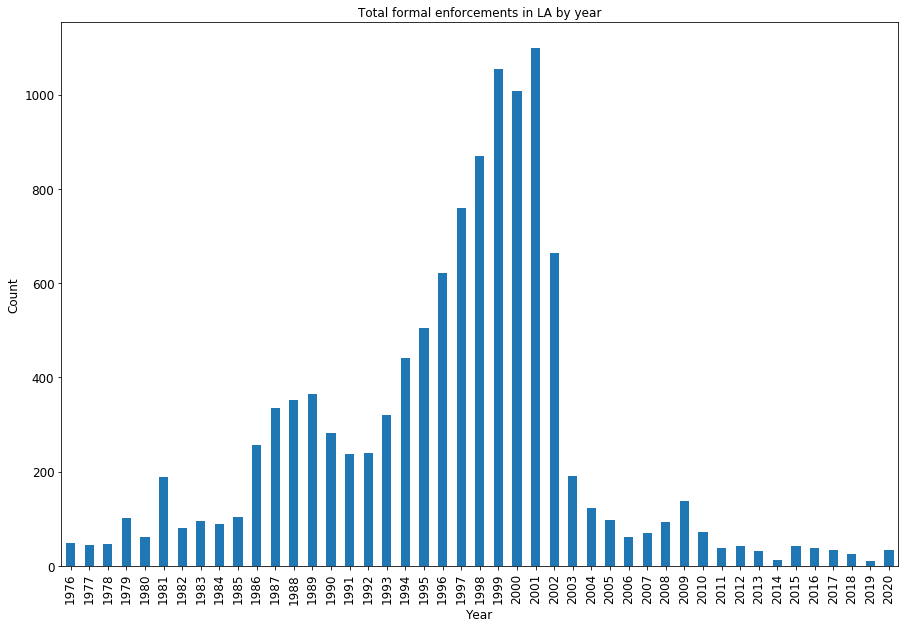

In [28]:
year_groups = icis_data.groupby("CASE_STATUS_DATE")[["CASE_STATUS_DATE"]]
counted_years = year_groups.count()

# Print how many values are present 
print(counted_years)
chart_title = "Total formal enforcements in " + my_state + " by year"

ax = counted_years[['CASE_STATUS_DATE']].plot(kind='bar', title = chart_title, figsize=(15, 10), legend=False, fontsize=12)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.show()

